In [1]:
import numpy as np
from jax import numpy as jnp
import jax

from limepydf_interpolate_jax import limepy_interpolate
from coordinate_transform_jax import StC


from math import pi
#This class is created with every given data!
#For every different data, we need a class to compute df

#With full data only estimate centers and structural parameters
class log_df_full_data:
    def __init__(self,vecx,vecv,data_type='complete'):
        #Only Need to initialize once to create a method for limepy interpolated df
        a = limepy_interpolate()
        self.my_df = a.my_df
        self.coefficient_boundary = a.coefficient_boundary
        if data_type=='complete':
            self.vec_x = jnp.array(vecx)
            self.vec_v = jnp.array(vecv)
            self.like = jax.jit(self.log_df_cartesian_complete)
            self.likegrad = jax.jit(jax.grad(self.log_df_cartesian_complete))
        else:
            self.Nop = jnp.shape(self.vec_x)[1] #Needs to check this line 
            if data_type=='Cartesian':
                self.like = jax.jit(self.log_df_cartesian)
                self.likegrad = jax.jit(jax.grad(self.log_df_cartesian))
            else:
                self.like = jax.jit(self.log_df_sky)
                self.likegrad = jax.jit(jax.grad(self.log_df_sky))

    def log_df_cartesian_complete(self,ii):   
        r = jnp.sqrt((self.vec_x[0]-ii[4])**2+(self.vec_x[1]-ii[5])**2+(self.vec_x[2]-ii[6])**2)
        v = jnp.sqrt((self.vec_v[0]-ii[7])**2+(self.vec_v[1]-ii[8])**2+(self.vec_v[2]-ii[9])**2) 
        fr = self.my_df(r,v,ii[:4])
        return fr
    
    #now we completely do not know about rz distance!
    #so rz center is not included
    def log_df_cartesian(self,ii):  
        Np = self.Nop
        r = jnp.sqrt((ii[9:9+Np]-ii[4])**2+(ii[9+Np:9+2*Np]-ii[5])**2+(ii[9+2*Np:9+3*Np]-ii[6])**2)
        v = jnp.sqrt((ii[9+3*Np:9+4*Np]-ii[7])**2+(ii[9+4*Np:9+5*Np]-ii[8])**2+(ii[9+5*Np:9+6*Np])**2) 
        fr = self.my_df(r,v,ii[:4])
        return fr

    def log_df_sky(self,ii):  
        Np = self.Nop
        
        p_f = 1000/(ii[10+2*Np:10+3*Np]+1000/ii[6])
        xc_f,yc_f,zc_f,vxc_f,vyc_f,vzc_f = StC(jnp.array([ii[4],ii[5],ii[6],ii[7],ii[8],ii[9]]))
        x_f,y_f,z_f,vx_f,vy_f,vz_f = StC(jnp.array([ii[10:10+Np],ii[10+Np:10+2*Np],p_f,\
                                                   ii[10+3*Np:10+4*Np],ii[10+4*Np:10+5*Np],(ii[10+5*Np:10+6*Np]+ii[9])]))

        r = jnp.sqrt((x_f-xc_f)**2+(y_f-yc_f)**2+(z_f-zc_f)**2)
        v = jnp.sqrt((vx_f-vxc_f)**2+(vy_f-vyc_f)**2+(vz_f-vzc_f)**2) 
        
        #we have to correct for the coordinate sampling error!
        #The Jacobian term is included to correct for the sampling process
        fr = self.my_df(r,v,ii[:4])+jnp.sum(jnp.log(jnp.abs((ii[10+2*Np:10+3*Np]+1000/ii[6])**4*jnp.cos(ii[10+Np:10+2*Np]))))
        
        #Gaussian likelihood on individual parallax! 
        #p_l = -jnp.sum(jnp.log(sigma_p*(2*pi)**(1/2))+1/2*((p_obs-p_f)/sigma_p)**2)
        return fr#+p_l

from external_likeilhood_aesara import flogLike_with_grad

import aesara.tensor as at
import aesara

class Bayesian_sampling:
    def __init__(self,vecx,vecv,test_param,data_type='complete'):

        f_like = log_df_full_data(vecx,vecv,data_type=data_type)
        self.coefficient_boundary = f_like.coefficient_boundary
        
        #We need to compile the two functions before sending to pymc
        print(f_like.like(test_param))
        print(f_like.likegrad(test_param))
        self.logl = flogLike_with_grad(f_like.like,f_like.likegrad)

        #position mean, position max with respect to their arrays
        self.pmin, self.pmax = np.min(vecx,axis=1), np.max(vecx,axis=1)
        self.vmin, self.vmax = np.min(vecv,axis=1), np.max(vecv,axis=1)
    
    #This is the aesara function used to cutoff Phi0 results
    def boundary_func_aesara(self,x,offset=0.2):
        #if we make coefficients as input, this will be a generic np.poly1d function
        #Here the coefficients are from small to big (from zero degree to higher degree)
        coefficients = at.as_tensor_variable(np.flip(self.coefficient_boundary))
        max_coefficients_supported = 10000
        components, updates = aesara.scan(fn=lambda coefficient, power, free_variable: coefficient * (free_variable ** power),
                                    outputs_info=None,
                                    sequences=[coefficients, at.arange(max_coefficients_supported)],
                                    non_sequences=x)
        polynomial = components.sum(axis=0)-offset
        return polynomial
    

In [2]:
from limepy import limepy, sample


#only contains numpy array here
#Here this is simply the Cartesian version
def simulate_limepy(struct_param,center_param,Np=1000):
    W0true, gtrue,log10Mtrue,rhtrue = struct_param
    xtrue, ytrue,ztrue, vxtrue, vytrue, vztrue = center_param

    k = limepy(W0true, gtrue, M=10**log10Mtrue, rh=rhtrue)
    ic = sample(k,N=Np)

    vecx_np = np.array([ic.x+xtrue,ic.y+ytrue,ic.z+ztrue])
    vecv_np = np.array([ic.vx+vxtrue,ic.vy+vytrue,ic.vz+vztrue])

    return vecx_np,vecv_np

In [3]:
import numpy as np
ip = [5.0,2.0,np.log10(1e5),3.0]
ic = [2,3,4,0.2,0.3,0.4]
xhhh = np.array(ip+ic)
datax,datav= simulate_limepy(ip,ic)
B_S = Bayesian_sampling(datax,datav,xhhh)

-15442.577716687389
[   8.37221467    3.08881413 -392.03117712   27.83764471  -15.89030668
    1.54028789   -1.1740213    -0.6976        3.73562446    0.88664478]


In [4]:
#xhhh = np.array(ip+ic)
#f_like = log_df_full_data(datax,datav)
#f_like.like(xhhh)
#f_like.likegrad(xhhh)

In [5]:
#The parallal functions are fine here!

import arviz as az
import pymc as pm
#Prior is still not added yet!
#aesara.config.linker = "cvm"

ndraws = 3000  # number of draws from the distribution
nburn = 1000 # number of "burn-in points" (which we'll discard)

basic_model = pm.Model()
with basic_model:
    W0 = pm.Uniform("Phi0",lower=1.5,upper=14)
    g = pm.Uniform("g",lower=0.001,upper=B_S.boundary_func_aesara(W0))

    log10M = pm.Normal("log10M",mu=5.85,sigma=0.6)
    rh = pm.TruncatedNormal("rh", mu=3.4,sigma=0.4,lower=0,upper=30)
    
    xc  = pm.Uniform("xc",lower=B_S.pmin[0],upper=B_S.pmax[0])
    yc  = pm.Uniform("yc",lower=B_S.pmin[1],upper=B_S.pmax[1])
    zc  = pm.Uniform("zc",lower=B_S.pmin[2],upper=B_S.pmax[2])
    vxc  = pm.Uniform("vxc",lower=B_S.vmin[0],upper=B_S.vmax[0])
    vyc  = pm.Uniform("vyc",lower=B_S.vmin[1],upper=B_S.vmax[1])
    vzc  = pm.Uniform("vzc",lower=B_S.vmin[2],upper=B_S.vmax[2])  

    theta = at.stack([W0,g,log10M,rh,xc,yc,zc,vxc,vyc,vzc])
    
    pm.Potential("like", B_S.logl(theta))
    
    step = pm.NUTS() 
    idata = pm.sample(ndraws,tune=nburn,chains=4,step=step,discard_tuned_samples=False)

ERROR:pymc:There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 80 divergences after tuning. Increase `target_accept` or reparameterize.


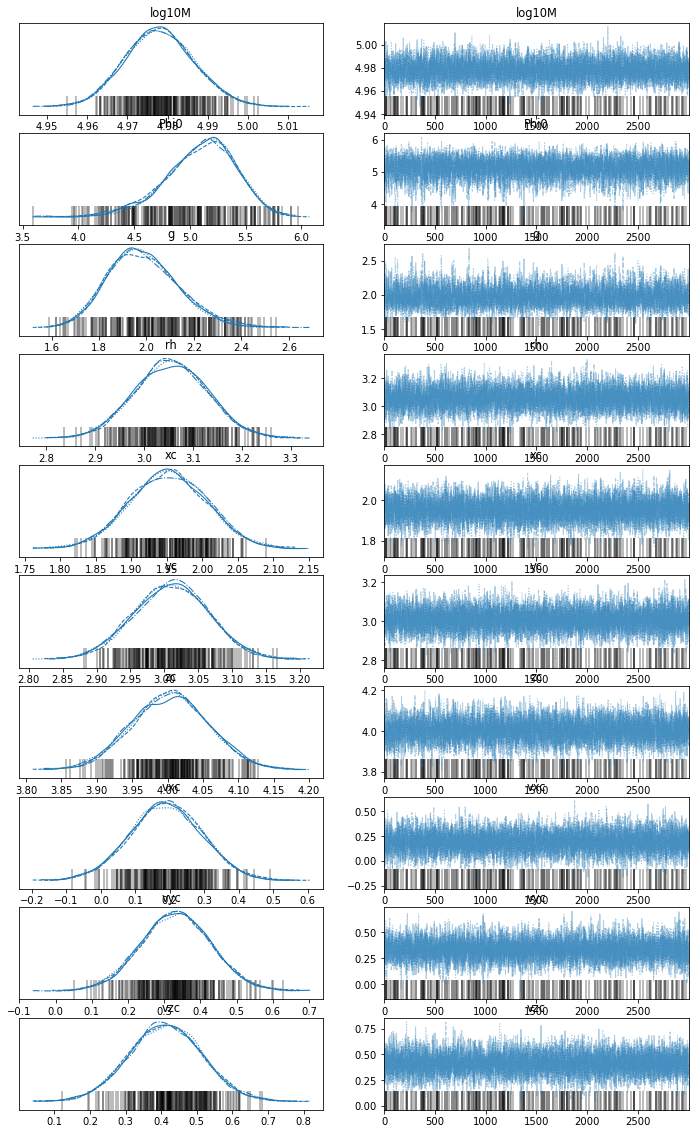

In [6]:
_ = az.plot_trace(idata)

Removed no burn in
Removed no burn in


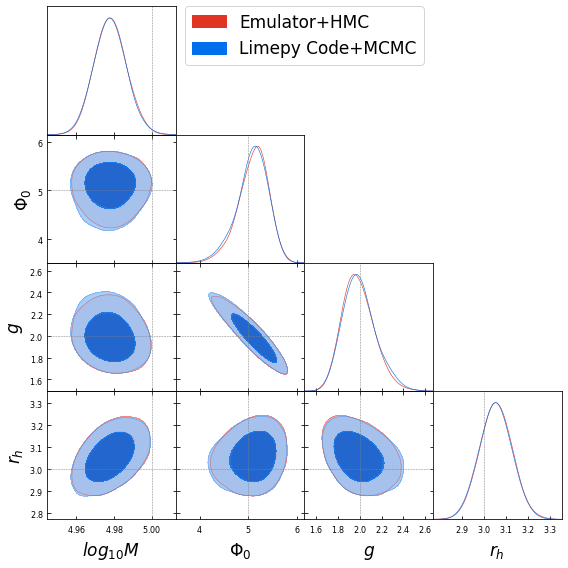

In [7]:
df = idata.to_dataframe()
df_np = df.to_numpy()
import pandas as pd
dflp = pd.read_csv('../Interpolation-LimepyDF/limepy_5235.csv') 

from getdist import plots, MCSamples

names = ["log10M","Phi0","g","rh","xc","yc","zc","vxc","vyc","vzc"]
labels =  ["log_{10}M","\Phi_0","g","r_h","x_c","y_c","z_c","vx_c","vy_c","vz_c"]
samples = MCSamples(samples=(df_np[:,2:12]).astype('float32'),names = names, labels = labels)

names = ["log10M","g","Phi0","rh","xc","yc","zc","vxc","vyc","vzc"]
labels =  ["log_{10}M","g","\Phi_0","r_h","x_c","y_c","z_c","vx_c","vy_c","vz_c"]
samples_lp = MCSamples(samples=dflp.to_numpy() ,names = names, labels = labels)

m = plots.GetDistPlotSettings()
m.legend_fontsize = 20
m.axes_labelsize = 20

#results use slicing methods
g = plots.get_subplot_plotter(settings = m)
g.triangle_plot([samples,samples_lp], filled=True, params=["log10M","Phi0","g","rh"],\
                markers={"g": ip[1], "Phi0": ip[0], "log10M": 5, "rh": ip[3]},\
                legend_labels=['Emulator+HMC','Limepy Code+MCMC'])